<a href="https://colab.research.google.com/github/Murcicrum/analisis-legislativo/blob/main/analisis_legislativo__primer_exploracion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports y carga del drive

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive


In [8]:
#https://github.com/Murcicrum/analisis-legislativo/raw/main/VotNom_129-137_cabecera.csv
URL_CABECERA = 'https://github.com/Murcicrum/analisis-legislativo/raw/main/VotNom_cabecera.csv'
URL_DETALLES = 'https://github.com/Murcicrum/analisis-legislativo/raw/main/VotNom_detalles.csv'

df_cab = pd.read_csv( URL_CABECERA )
df_det = pd.read_csv( URL_DETALLES )

print( 'Shape de Cabecera: ',df_cab.shape)
print( 'Shape de Detalles: ',df_det.shape )

Shape de Cabecera:  (999, 22)
Shape de Detalles:  (256743, 8)


In [4]:
print('Columnas de Cabecera: \n', df_cab.columns)
print('\nColumnas de Detalles: \n', df_det.columns)

Columnas de Cabecera: 
 Index(['Unnamed: 0', 'abstenciones', 'acta_id', 'ausentes', 'base_mayoria',
       'fecha', 'hora', 'nroperiodo', 'numero', 'persona_id', 'presidente_id',
       'presidente_nombre', 'resultado', 'reunion', 'sesion', 'sesion_id',
       'tipo_mayoria', 'tipo_periodo', 'tipo_sesion', 'titulo',
       'votos_afirmativos', 'votos_negativos'],
      dtype='object')

Columnas de Detalles: 
 Index(['Unnamed: 0', 'acta_id', 'acta_detalle_id', 'diputado_nombre',
       'persona_id', 'bloque', 'distrito_nombre', 'voto'],
      dtype='object')


#Exploración

####Sobre NaNs

Veo los nans

In [ ]:
df_det[ (df_det.isnull().any(axis=1)) ].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 30840 to 256486
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   acta_id          162 non-null    int64 
 1   acta_detalle_id  162 non-null    int64 
 2   diputado_nombre  0 non-null      object
 3   persona_id       162 non-null    object
 4   bloque           57 non-null     object
 5   distrito_nombre  162 non-null    object
 6   voto             162 non-null    object
dtypes: int64(2), object(5)
memory usage: 10.1+ KB


Hay 162 filas con NaNs, en todas ellas falta el diputado_nombre.

Cuento cuantos diputados faltan por cada acta:

In [ ]:
df_det.groupby(['acta_id']).diputado_nombre.agg('count').value_counts()

257    864
256    126
253      9
Name: diputado_nombre, dtype: int64

En 9 actas hay 253 diputados (faltan 4), en 126 hay 256 (falta1 ).

Guardo las actas con diputados ausentes:

Veo como figuran los votos de esos nans:

In [ ]:
df_det[ (df_det.isnull().any(axis=1)) ].voto.value_counts()

AUSENTE    162
Name: voto, dtype: int64

#Calculador de coincidencias

In [ ]:
#diputs = df_det.diputado_nombre.unique()                                        #Guardo los nombres de todos los diputados
#cant_diputs = len( diputs )

#####Sobre cada periodo, con los diputados de ese periodo

In [ ]:
sorted_periods = df_cab.nroperiodo.unique().copy()
sorted_periods.sort()

coincidencias_d = []
cortes_d = []

d_peract = {}
print('Calculando coincidencias...')

for periodo in sorted_periods:

  print('\tPeriodo ', periodo)

#Guardo las actas que se trataron en ese periodo
  actas = df_cab[ df_cab['nroperiodo']==periodo ].acta_id.unique()
#y cuantas hubo, para poder normalizar al final
  d_peract[periodo] = len(actas)
  
#Guardo los nombres de todos los diputados activos en esas actas
#ordenados por el nombre del bloque que representan


  df_aux = df_det[ df_det.acta_id.isin( actas ) ]#.sort_values(by='bloque',ignore_index=True)
  
  df_aux['freq'] = df_aux.groupby('bloque')['bloque'].transform('count')
  
  df_aux.sort_values(['freq','bloque'], ascending=False, ignore_index=True, inplace=True)
  df_aux.dropna( inplace=True )
  
  df_aux['nro_bloque'] = [ np.where( df_aux.freq.unique() == f )[0][0] for f in df_aux.freq ]
  
  diputs = df_aux.diputado_nombre.unique()

  cant_diputs = len( diputs )
  
  values = []
  
  for d in diputs:
    values.append( (d,
                    df_aux[ df_aux.diputado_nombre==d ].bloque.unique()[0],
                    df_aux[ df_aux.diputado_nombre==d ].nro_bloque.unique()[0] ) )

  dipbloqs = pd.DataFrame( data=values, columns=['nombre','bloque','nro_bloque'] )
  cortes = dipbloqs[:-1].iloc[ dipbloqs.bloque.to_numpy()[1:] != dipbloqs.bloque.to_numpy()[:-1] ]
  cortes_per = []
  for i,b in zip(cortes.index, cortes.bloque):
    cortes_per.append( (i,b) )



#Calculo de las coincidencias en cada acta
  coincidencias_per = np.zeros( shape=(cant_diputs,cant_diputs) )

  for n, act in enumerate(actas):                                                 #Para cada acta
    
    df_act = df_det[ df_det.acta_id == act ]                                      #Armo un dataframe auxiliar sólo de esa acta

#Busco las coincidencias en ese periodo
    for voto in ['AFIRMATIVO', 'NEGATIVO', 'AUSENTE', 'ABSTENCION']:              #Por cada tipo de voto posible
      coinc_diputs = df_act[ df_act.voto==voto ].diputado_nombre                  #Levanto los nombres de diputados que tengan el mismo tipo de voto

      coinc_indexs = np.asarray([ np.where(diputs==cd)[0][0] for cd in coinc_diputs       #Me fijo en que indice de diputs está cada uno de esos diputados
                                                              if type(cd)!=float ])       #los nombres son str, pero los NaN los guarda como floats y quiero descartarlos

#LLeno la matriz
      for i, ind in enumerate( coinc_indexs ):                                    #Por cada indice 'ind' en la lista de indices de coincidencias

        for ond in coinc_indexs[i:]:                                              #Saco otro indice 'ond' de los últimos i indices. Esto es así para no repetir cuentas, porque la matriz es simétrica
          if ind == ond:                                                          #Si saqué dos indices iguales, i.e. si estoy sobre la diagonal, lo omito y paso al siguiente
            pass                                                                  #Lo puse así porque sino se satura la diagonal
            #coincidencias[ind,ind] += 1
          else:                                                                   #Si saqué dos indices distintos
            coincidencias_per[ind,ond] += 1                                           #sumo uno en esos lugar de la matriz de coincidencias
            coincidencias_per[ond,ind] += 1

#Normalizo por la cantidad de actas en ese periodo  
  coincidencias_per = coincidencias_per/d_peract[periodo]

  cortes_d.append( cortes_per )
  coincidencias_d.append( coincidencias_per )

Calculando coincidencias...
	Periodo  129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  130


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  134


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

	Periodo  137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launch

#####Graficos separados

In [ ]:
!mv comportamiento* drive/MyDrive

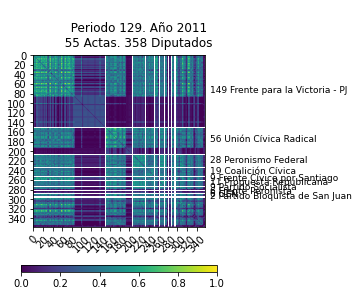

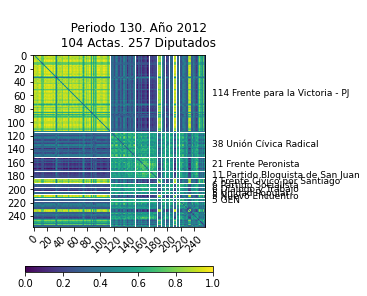

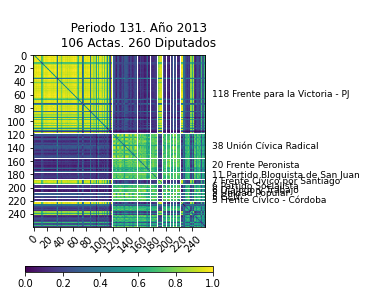

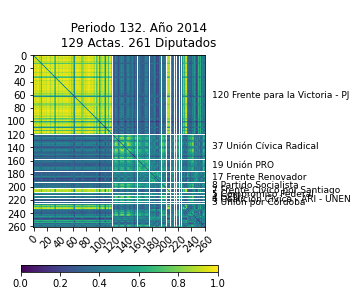

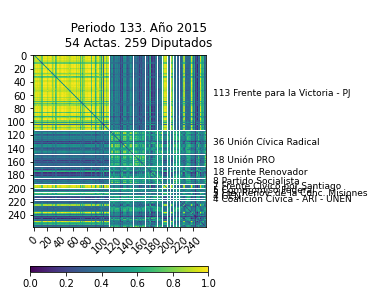

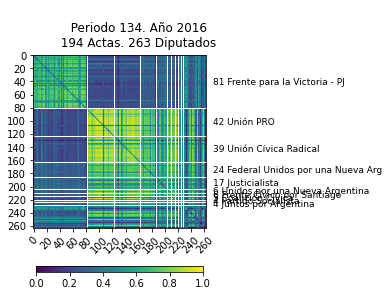

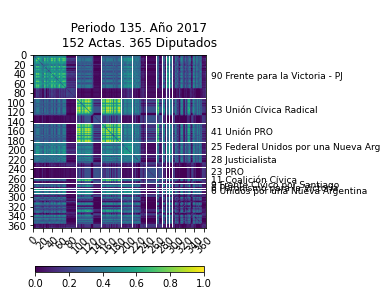

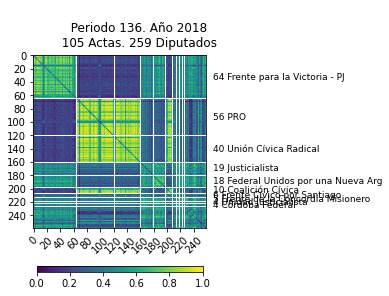

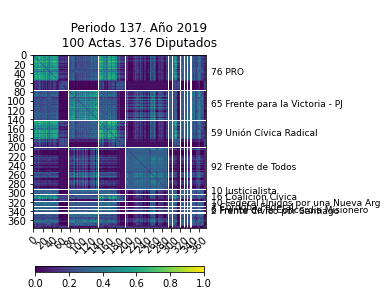

In [ ]:
for i, [matriz,cortes] in enumerate( zip(coincidencias_d, cortes_d) ):

  fig, ax = plt.subplots( 1,1, constrained_layout=True )  
  
  im = ax.imshow( matriz )
  
  title = f'''
          Periodo {sorted_periods[i]}. Año {sorted_periods[i]+1882}
          {d_peract[sorted_periods[i]]} Actas. {matriz.shape[0]} Diputados
           '''
  ax.set_title( title, fontsize=12, y=0.925)
  ax.set_xticks( range(0,matriz.shape[0], 20) )
  ax.set_yticks( range(0,matriz.shape[0], 20) )
  ax.tick_params(axis='x', labelrotation = 45)

  cortes = [(0,'')] + cortes
  for n in range(1,11):
    ax.text( s=f'{cortes[n][0]-cortes[n-1][0]} {cortes[n][1]}'[:35], fontsize=9,
             x=matriz.shape[0]+10, y=(cortes[n-1][0]+cortes[n][0])/2+4)

    ax.vlines( cortes[n][0] ,0,matriz.shape[0]-1, colors='w', linewidths=1)
    ax.hlines( cortes[n][0] ,0,matriz.shape[0]-1, colors='w', linewidths=1)

  fig.colorbar(im, ax=ax, shrink=0.50, orientation='horizontal')

  fig.savefig(f'comportamiento_bloques_{sorted_periods[i]}-{sorted_periods[i]+1882}')

#####Graficos juntos

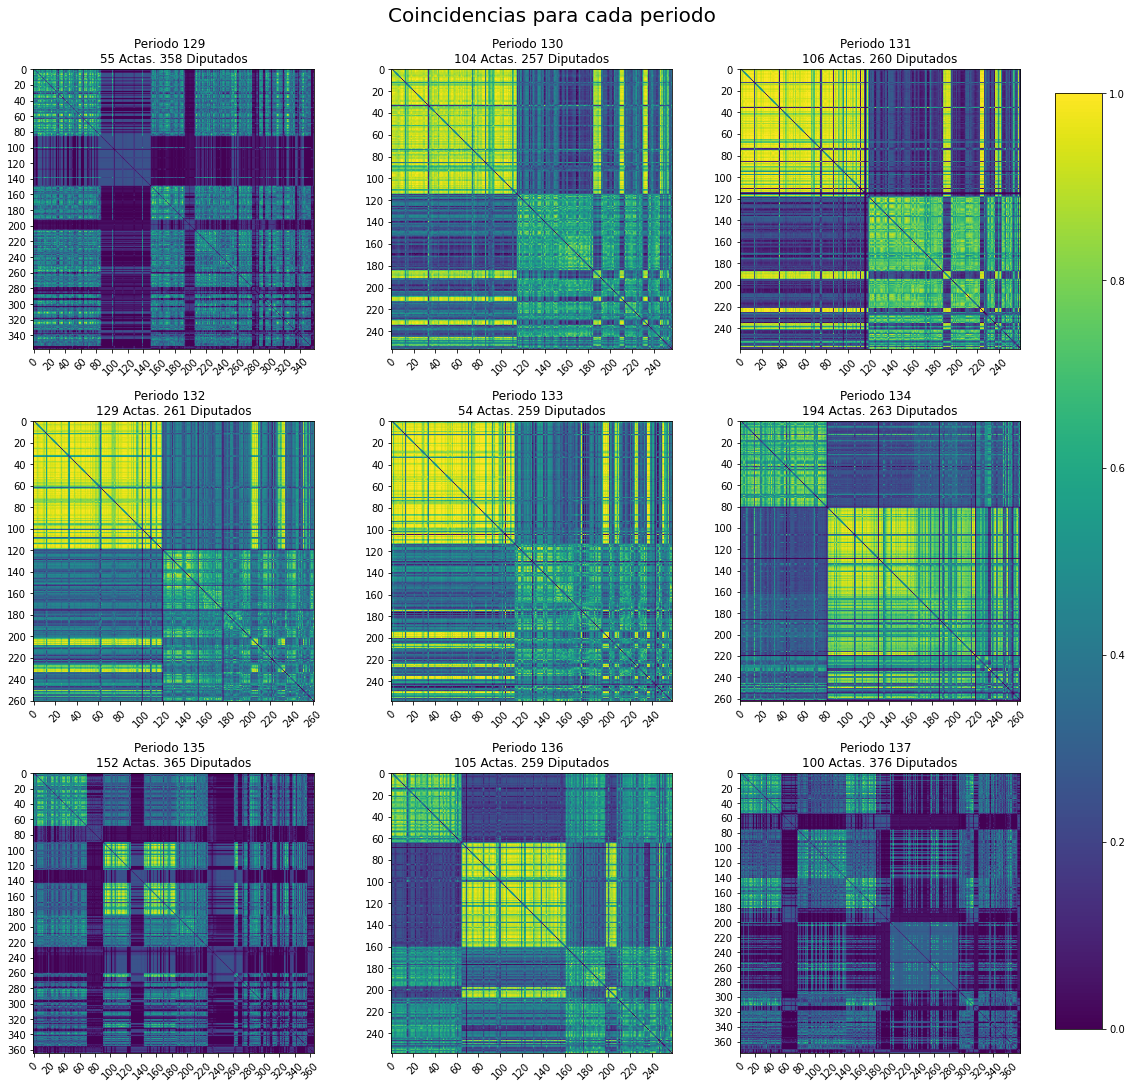

In [ ]:
fig, axs = plt.subplots( 3,3,figsize=(16,15), constrained_layout=True )

for i, [ax, matriz] in enumerate( zip(axs.flat,coincidencias_d) ):
  
  im = ax.imshow(matriz)
  ax.set_title(f'Periodo {sorted_periods[i]}  \n{d_peract[sorted_periods[i]]} Actas. {matriz.shape[0]} Diputados')
  ax.set_xticks( range(0,matriz.shape[0], 20) )
  ax.set_yticks( range(0,matriz.shape[0], 20) )
  ax.tick_params(axis='x', labelrotation = 45)
fig.suptitle('Coincidencias para cada periodo', fontsize='20')
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95 )

#Comportamiento de bloques

In [ ]:
apoyos_x_actas = []
N_BLOQUES_MAYORITARIOS = 6
for j,acta in enumerate(df_cab.acta_id):
  
  df_acta = df_det[ df_det.acta_id==acta ]
  bloques_mayoritarios = df_acta.bloque.value_counts().index[:N_BLOQUES_MAYORITARIOS]

  apoyos = {}
#un poco de info sobre el acta
  apoyos['acta_id'] = acta
  
  periodo = df_cab[ df_cab.acta_id==acta ].nroperiodo.values[0]
  
  #Si el bloque mayoritario pertenece al oficialismo
  bloque_principal = bloques_mayoritarios[0]
  #Considerando que en periodo133/año2015 el PJ era oficialista, para ser consitente debo considerarlo oposición en el periodo137/año2018
  es_oficialismo = periodo <= 133 and bloque_principal=='Frente para la Victoria - PJ'
  if es_oficialismo:  apoyos['es_oficialismo'] = 1
  else:               apoyos['es_oficialismo'] = 0

#Calculo los indices de apoyo y presencia de los bloques mayoritarios
  for i,bloque in enumerate( bloques_mayoritarios ):

    votos_total     = len( df_acta[ (df_acta.bloque==bloque) ] )
    votos_afirmativo= len( df_acta[ (df_acta.bloque==bloque) & (df_acta.voto=='AFIRMATIVO') ] )
    votos_negativo  = len( df_acta[ (df_acta.bloque==bloque) & (df_acta.voto =='NEGATIVO' ) ] )
    votos_ausente   = len( df_acta[ (df_acta.bloque==bloque) & (df_acta.voto == 'AUSENTE' ) ] )

    presencia = ( votos_total - votos_ausente )   /  votos_total
    if presencia:
      apoyo = (votos_afirmativo - votos_negativo )  /  ( votos_total - votos_ausente )
    else: 
      apoyo = None

    apoyos[str(i)+'_presencia'] = presencia
    apoyos[str(i)+'_apoyo'] = apoyo
  
  apoyos_x_actas.append( apoyos )

Meto esto en un nuevo dataset

In [ ]:
df_apoyos = pd.DataFrame(data = apoyos_x_actas )
df_apoyos

,acta_id,es_oficialismo,0_presencia,0_apoyo,1_presencia,1_apoyo,2_presencia,2_apoyo,3_presencia,3_apoyo,4_presencia,4_apoyo,5_presencia,5_apoyo
0,3761,0,0.676923,0.977273,0.981818,-1.000000,0.950000,-1.000000,0.526316,1.0,0.764706,1.0,1.000000,-1.0
1,3762,0,0.753846,0.918367,0.890909,1.000000,0.975000,1.000000,0.736842,1.0,0.882353,1.0,0.900000,1.0
2,3763,0,0.830769,1.000000,0.927273,1.000000,0.975000,1.000000,0.736842,1.0,0.882353,1.0,0.900000,1.0
3,3764,0,0.753846,1.000000,0.927273,1.000000,0.950000,1.000000,0.631579,1.0,0.882353,1.0,0.900000,1.0
4,3765,0,0.830769,-1.000000,0.963636,1.000000,0.950000,1.000000,0.736842,1.0,0.941176,-1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,3959,0,0.983333,1.000000,0.764706,-1.000000,0.808511,-1.000000,0.800000,-1.0,0.750000,1.0,0.666667,1.0
995,3960,0,0.932773,1.000000,0.745098,1.000000,0.936170,1.000000,1.000000,1.0,0.500000,1.0,0.666667,1.0
996,3961,0,0.915966,1.000000,0.666667,0.529412,0.893617,-0.547619,0.933333,-1.0,0.500000,1.0,0.666667,1.0
997,3962,0,0.907563,1.000000,0.666667,1.000000,0.893617,1.000000,0.866667,1.0,0.500000,1.0,0.666667,1.0


#####Un poquitito de exploración

In [ ]:
df_apoyos[[ c for c in df_apoyos.columns if c[1:]=='_apoyo' ]].describe()

,0_apoyo,1_apoyo,2_apoyo,3_apoyo,4_apoyo,5_apoyo
count,992.000000,947.000000,942.000000,938.000000,987.000000,944.000000
mean,0.577525,0.390771,0.371505,0.542859,0.650940,0.655089
std,0.786122,0.886671,0.898792,0.763070,0.700321,0.715951
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.913043,-0.937500,-1.000000,0.291667,0.846154,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_apoyos[[ c for c in df_apoyos.columns if c[1:]=='_presencia' ]].describe()

,0_presencia,1_presencia,2_presencia,3_presencia,4_presencia,5_presencia
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,0.817336,0.778418,0.740368,0.650454,0.750892,0.770423
std,0.170758,0.227079,0.266969,0.255204,0.208716,0.270081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.723077,0.707317,0.700000,0.521739,0.647059,0.666667
50%,0.861538,0.857143,0.833333,0.705882,0.764706,0.833333
75%,0.947368,0.926829,0.915780,0.833333,0.882353,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Histogramas

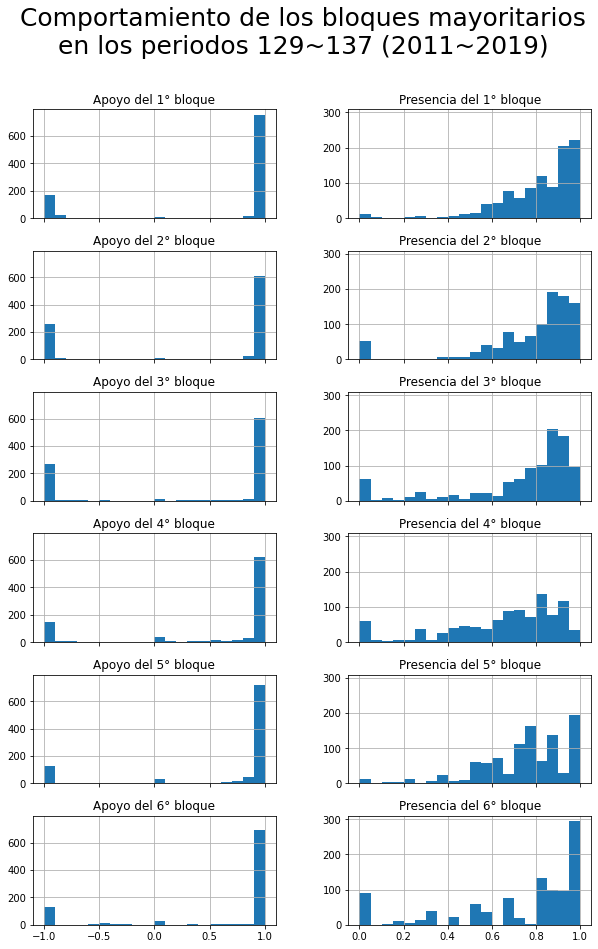

In [ ]:
#Vertical
fig, axs = plt.subplots( 6,2, sharex='col', sharey='col', figsize=(10,15))

for i in range(6):

  df_apoyos.hist(column=f'{i}_apoyo',     ax=axs[i,0], bins=20)
  axs[i,0].set_title( f'Apoyo del {i+1}° bloque' )
  df_apoyos.hist(column=f'{i}_presencia', ax=axs[i,1], bins=20)
  axs[i,1].set_title( f'Presencia del {i+1}° bloque' )

fig.suptitle(t='Comportamiento de los bloques mayoritarios\nen los periodos 129~137 (2011~2019)',
             fontsize=25, y=0.975)
fig.savefig('Comportamiento_mayoritarios.png')

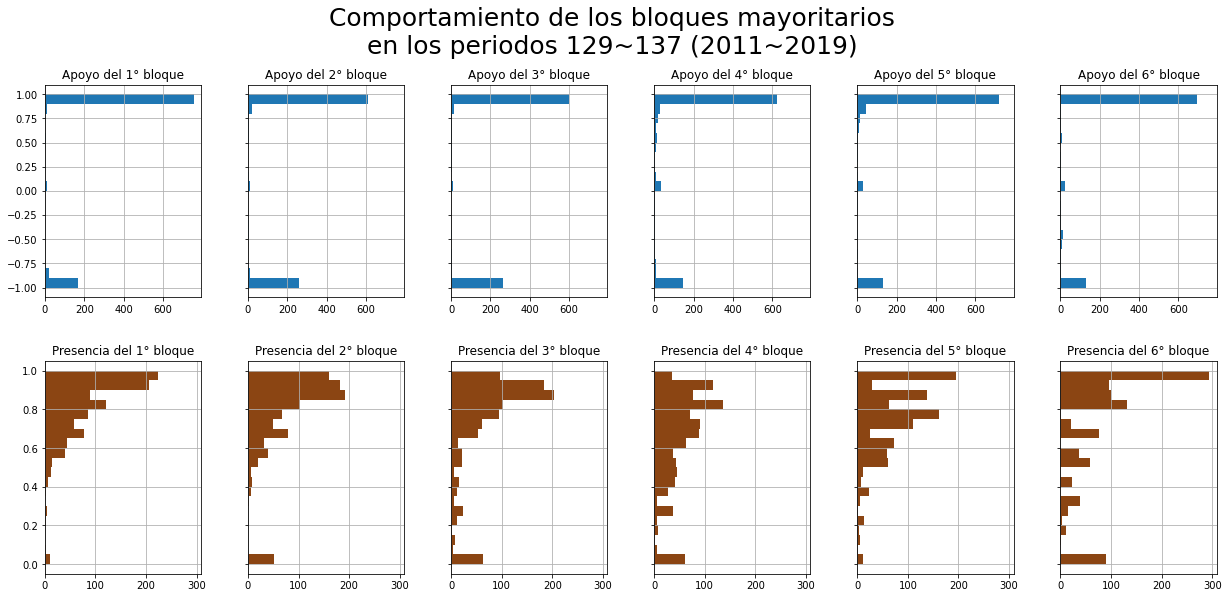

In [ ]:
#Horizontal
fig, axs = plt.subplots( 2,6, sharex='row', sharey='row', figsize=(21,9))


for i in range(6):

  df_apoyos.hist(column=f'{i}_apoyo',     ax=axs[0,i], bins=20, orientation='horizontal')
  axs[0,i].set_title( f'Apoyo del {i+1}° bloque' )

  df_apoyos.hist(column=f'{i}_presencia', ax=axs[1,i], bins=20, orientation='horizontal', color='saddlebrown')
  axs[1,i].set_title( f'Presencia del {i+1}° bloque' )


fig.suptitle(t='Comportamiento de los bloques mayoritarios\nen los periodos 129~137 (2011~2019)',
             fontsize=25, y=1)
fig.savefig('comportamiento_mayoritarios.png')

Matrices de correlación

In [ ]:
df_apoyos.columns

Index(['acta_id', 'es_oficialismo', '0_presencia', '0_apoyo', '1_presencia',
       '1_apoyo', '2_presencia', '2_apoyo', '3_presencia', '3_apoyo',
       '4_presencia', '4_apoyo', '5_presencia', '5_apoyo'],
      dtype='object')

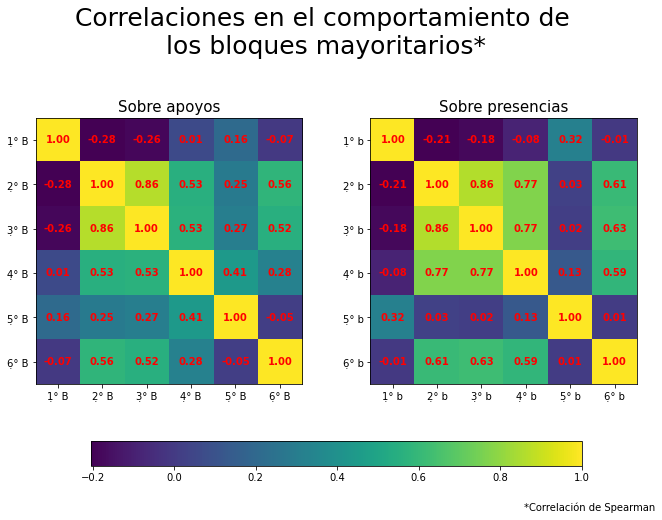

In [ ]:
fig, axs = plt.subplots( 1,2, figsize=(11,7))


apoyo_matcorr = df_apoyos[[ c for c in df_apoyos.columns if c[1:]=='_apoyo' ]].corr(method='spearman') #type = pd.DataFrame
apoyo_pltcorr = axs[0].imshow( apoyo_matcorr )
for i in range(len(apoyo_matcorr)):
  for j in range(len(apoyo_matcorr)):
    axs[0].text(i,j, f'{apoyo_matcorr.to_numpy()[i,j]:.2f}',
                ha='center', va='center', color='r', fontweight='bold')

axs[0].set_title( 'Sobre apoyos', fontsize=15)
axs[0].set_xticklabels([ f'{n}̣° B' for n in range(7)])
axs[0].set_yticklabels([ f'{n}̣° B' for n in range(7)])



presencia_matcorr = df_apoyos[[ c for c in df_apoyos.columns if c[1:]=='_presencia' ]].corr()
presencia_pltcorr= axs[1].imshow( presencia_matcorr)
for i in range(len(presencia_matcorr)):
  for j in range(len(presencia_matcorr)):
    axs[1].text(i,j, f'{presencia_matcorr.to_numpy()[i,j]:.2f}',
                ha='center', va='center', color='r', fontweight='bold')

axs[1].set_title( 'Sobre presencias', fontsize=15 )
axs[1].set_xticklabels([ f'{n}̣° b' for n in range(7)])
axs[1].set_yticklabels([ f'{n}̣° b' for n in range(7)])



fig.suptitle('Correlaciones en el comportamiento de \nlos bloques mayoritarios*',
             fontsize=25, y=1.1)
fig.text(x=0.75,y=0.1, s='*Correlación de Spearman')
fig.colorbar(presencia_pltcorr, ax=axs.ravel().tolist(), orientation='horizontal',shrink=0.8)
fig.savefig('comportamiento_correlaciones.png')

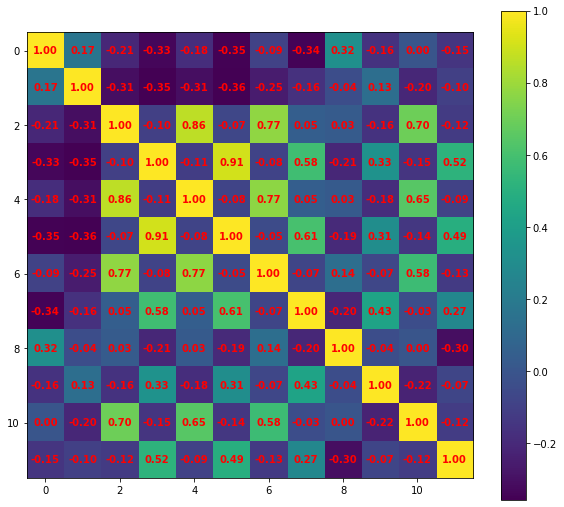

In [ ]:
plt.figure( figsize=(10,10) )

matcorr = df_apoyos[[ c for c in df_apoyos.columns if c not in ['acta_id', 'nroperiodo', 'es_oficialismo'] ]].corr()
pltcorr = plt.imshow( matcorr )
plt.colorbar(pltcorr, shrink=0.9)

for i in range(len(matcorr)):
  for j in range(len(matcorr)):
    plt.text(i,j, f'{matcorr.to_numpy()[i,j]:.2f}',
             ha='center', va='center', color='r', fontweight='bold')
#Arranca en 0_presencia,0_apoyo,1_presencia,1_apoyo....
#No hay correlaciones entre los apoyos y presencias de un mismo bloque

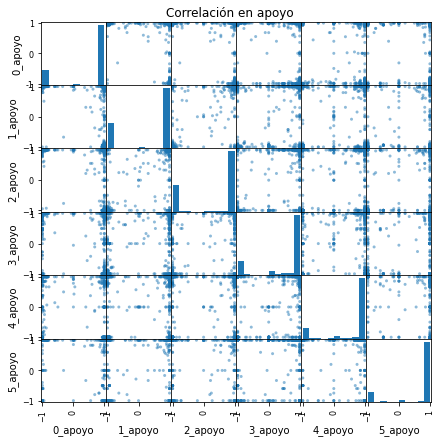

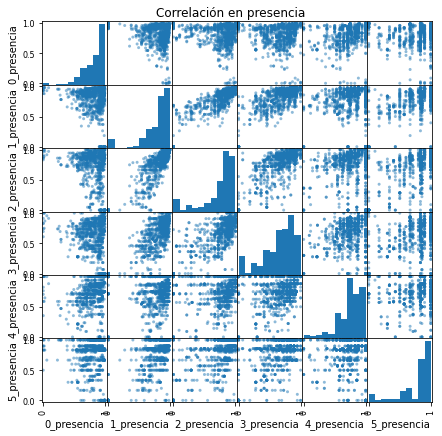

In [ ]:
for tipo in ['_apoyo', '_presencia']:
  pd.plotting.scatter_matrix(df_apoyos[[ c for c in df_apoyos.columns if c[1:]==tipo]], 
                             figsize=(7,7))
  plt.suptitle(f'Correlación en {tipo[1:]}', y=0.91 )


In [ ]:
df_cab['id_sesion'] = df_cab['nroperiodo'].astype(str)+'_'+df_cab['sesion'].astype(str)
df_cab['actas_x_sesion'] = df_cab.groupby('id_sesion')['id_sesion'].transform('count')
df_cab.drop('id_sesion', axis=1, inplace=True)

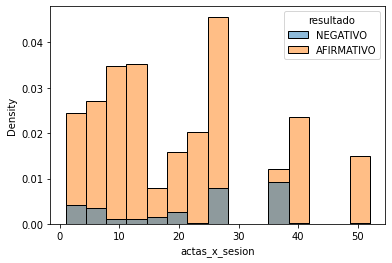

In [ ]:
sns.histplot(data=df_cab, x='actas_x_sesion', hue='resultado', 
             stat='density')

#Merge con columnas de df_cab

In [ ]:
print('Columnas de Cabecera \n', df_cab.columns)
print('\nColumnas de Apoyos \n', df_apoyos.columns)

Columnas de Cabecera 
 Index(['sesion_id', 'acta_id', 'nroperiodo', 'tipo_periodo', 'reunion',
       'sesion', 'tipo_sesion', 'numero', 'fecha', 'hora', 'base_mayoria',
       'tipo_mayoria', 'titulo', 'resultado', 'presidente_nombre',
       'persona_id', 'votos_afirmativos', 'votos_negativos', 'abstenciones',
       'ausentes', 'presidente_id', 'actas_x_sesion'],
      dtype='object')

Columnas de Apoyos 
 Index(['acta_id', 'es_oficialismo', '0_presencia', '0_apoyo', '1_presencia',
       '1_apoyo', '2_presencia', '2_apoyo', '3_presencia', '3_apoyo',
       '4_presencia', '4_apoyo', '5_presencia', '5_apoyo'],
      dtype='object')


In [ ]:
#Las clases están desbalanceadas 
df_cab.resultado.value_counts()

AFIRMATIVO    890
NEGATIVO      109
Name: resultado, dtype: int64

In [ ]:
COLUMNAS_MERGE = [ 'acta_id', 'nroperiodo', 'tipo_periodo', 'tipo_mayoria', 'tipo_sesion','resultado' ]
df_final = df_apoyos.merge( df_cab[ COLUMNAS_MERGE ], on='acta_id', how='inner')

In [ ]:
df_final = df_final.drop( columns=['acta_id','4_presencia', '4_apoyo', '5_presencia', '5_apoyo']).copy()
df_final

,es_oficialismo,0_presencia,0_apoyo,1_presencia,1_apoyo,2_presencia,2_apoyo,3_presencia,3_apoyo,nroperiodo,tipo_periodo,tipo_mayoria,tipo_sesion,resultado
0,0,0.676923,0.977273,0.981818,-1.000000,0.950000,-1.000000,0.526316,1.0,136,Ordinario,Dos tercios,Tablas,NEGATIVO
1,0,0.753846,0.918367,0.890909,1.000000,0.975000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,Tablas,AFIRMATIVO
2,0,0.830769,1.000000,0.927273,1.000000,0.975000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,Tablas,AFIRMATIVO
3,0,0.753846,1.000000,0.927273,1.000000,0.950000,1.000000,0.631579,1.0,136,Ordinario,Más de la mitad,Tablas,AFIRMATIVO
4,0,0.830769,-1.000000,0.963636,1.000000,0.950000,1.000000,0.736842,1.0,136,Ordinario,Más de la mitad,Tablas,AFIRMATIVO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,0.983333,1.000000,0.764706,-1.000000,0.808511,-1.000000,0.800000,-1.0,137,Extraordinario,Más de la mitad,Especial,AFIRMATIVO
995,0,0.932773,1.000000,0.745098,1.000000,0.936170,1.000000,1.000000,1.0,137,Extraordinario,Más de la mitad,Especial,AFIRMATIVO
996,0,0.915966,1.000000,0.666667,0.529412,0.893617,-0.547619,0.933333,-1.0,137,Extraordinario,Más de la mitad,Especial,AFIRMATIVO
997,0,0.907563,1.000000,0.666667,1.000000,0.893617,1.000000,0.866667,1.0,137,Extraordinario,Más de la mitad,Especial,AFIRMATIVO


#Transformo features

In [ ]:
#Resultado paso a 0-1
df_final['resultado'].replace(to_replace={'AFIRMATIVO':1,'NEGATIVO':0}, inplace=True)

#Tipo de mayoria
df_final['tipo_mayoria'].replace( to_replace={'Más de la mitad':0, 'La mitad más uno':0,
                                              'Dos tercios':1, 
                                              'Tres cuartos':2}, inplace=True )

In [ ]:
df_final

,es_oficialismo,0_presencia,0_apoyo,1_presencia,1_apoyo,2_presencia,2_apoyo,3_presencia,3_apoyo,nroperiodo,tipo_periodo,tipo_mayoria,tipo_sesion,resultado
0,0,0.676923,0.977273,0.981818,-1.000000,0.950000,-1.000000,0.526316,1.0,136,Ordinario,1,Tablas,0
1,0,0.753846,0.918367,0.890909,1.000000,0.975000,1.000000,0.736842,1.0,136,Ordinario,0,Tablas,1
2,0,0.830769,1.000000,0.927273,1.000000,0.975000,1.000000,0.736842,1.0,136,Ordinario,0,Tablas,1
3,0,0.753846,1.000000,0.927273,1.000000,0.950000,1.000000,0.631579,1.0,136,Ordinario,0,Tablas,1
4,0,0.830769,-1.000000,0.963636,1.000000,0.950000,1.000000,0.736842,1.0,136,Ordinario,0,Tablas,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,0.983333,1.000000,0.764706,-1.000000,0.808511,-1.000000,0.800000,-1.0,137,Extraordinario,0,Especial,1
995,0,0.932773,1.000000,0.745098,1.000000,0.936170,1.000000,1.000000,1.0,137,Extraordinario,0,Especial,1
996,0,0.915966,1.000000,0.666667,0.529412,0.893617,-0.547619,0.933333,-1.0,137,Extraordinario,0,Especial,1
997,0,0.907563,1.000000,0.666667,1.000000,0.893617,1.000000,0.866667,1.0,137,Extraordinario,0,Especial,1


In [ ]:
dummies_periodo = pd.get_dummies( data=df_final.tipo_periodo, prefix='periodo' )
dummies_sesion  = pd.get_dummies( data=df_final.tipo_sesion,  prefix='sesion'  )

In [ ]:
df_final = df_final.join( dummies_periodo ).copy()
df_final = df_final.join( dummies_sesion  ).copy()

In [ ]:
df_final.drop( columns=['tipo_sesion','tipo_periodo'], inplace=True )

Guardo el dataset

In [ ]:
df_final.to_csv('dataset_final.csv')